In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stockticker10tweets5321-label/stockticker10-tweets(5-3-21) label.csv
/kaggle/input/stockticker10tweets5321/stockticker10-tweets(5-3-21).csv
/kaggle/input/stockticker10tweetsdataset-23221/stockticker10-tweets(dataset 23-2-21).csv


In [5]:
# Plotting/Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import csv

from textblob import TextBlob
import re

import nltk
# nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>


In [6]:
df = pd.read_csv("../input/stockticker10tweets5321-label/stockticker10-tweets(5-3-21) label.csv")
df.head()

,Query,Datetime(UTC),Tweet ID,Text,Username,RT,RT Count,Fav Count,Sentiment (2pos/1neu/0neg),Subjectivity (1opinion/0fact)
0,$GME,5/3/2021 6:00,1.370000e+18,Think we're scared of the market makers?\n\n$A...,indigodisruptor,Y,9,0,NaN,NaN
1,$GME,5/3/2021 6:00,1.370000e+18,What these suits don’t know is $amc $gme wasn’...,Ladude2014,Y,5,0,NaN,NaN
2,$GME,5/3/2021 6:00,1.370000e+18,Holy shit LMFAO. \n$AMC $GME \n\nTRUST THE APE...,handsomephil5,Y,48,0,NaN,NaN
3,$GME,5/3/2021 6:00,1.370000e+18,"🔥 GUH: ""Fidelity closed out my shares of GME a...",WSBGains,N,0,0,0.0,1.0
4,$GME,5/3/2021 6:00,1.370000e+18,Amc Buy and hold Short Intrest borrow fee up t...,itsfibonacci96,Y,10,0,NaN,NaN


# Dataset Information

## Data dictionary
Details of the dataset:
  * Query
  * Datetime(UTC)
  * Tweet ID
  * Text
  * Username
  * RT: Y means is a retweet, N otherwise
  * RT Count
  * Fav Count
  * Sentiment (2pos/1neu/0neg)
  * Subjectivity (1opinion/0fact)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Query                          10000 non-null  object 
 1   Datetime(UTC)                  10000 non-null  object 
 2   Tweet ID                       10000 non-null  float64
 3   Text                           10000 non-null  object 
 4   Username                       10000 non-null  object 
 5   RT                             10000 non-null  object 
 6   RT Count                       10000 non-null  int64  
 7   Fav Count                      10000 non-null  int64  
 8   Sentiment (2pos/1neu/0neg)     1000 non-null   float64
 9   Subjectivity (1opinion/0fact)  1000 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 781.4+ KB


In [8]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    text = str(text)
    text = text.lower()
    text = text.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)
#     return filtered_words

df['cleanText'] = df['Text'].apply(preprocess)

In [9]:
df_cleanText = df.iloc[:,10]
df_cleanText

0       think scared market makers amc gme rkt sndl vi...
1       suits know amc gme stock movement people banne...
2            holy shit lmfao amc gme trust ape tradestrey
3       guh fidelity closed shares gme risk liquidatio...
4           amc buy hold short intrest borrow fee amc gme
                              ...                        
9995    apple clarifies siri setting default music ser...
9996    fsr bought red yesterday weak hands washed one...
9997    tsla ath aapl ath ath baba ath amzn ath bidu a...
9998    qqq hourly mar aapl algn amzn pypl crm snap re...
9999    spy spx etsy ndx qqq tsla pltr aapl amzn twtr ...
Name: cleanText, Length: 10000, dtype: object

In [10]:
df.head()

,Query,Datetime(UTC),Tweet ID,Text,Username,RT,RT Count,Fav Count,Sentiment (2pos/1neu/0neg),Subjectivity (1opinion/0fact),cleanText
0,$GME,5/3/2021 6:00,1.370000e+18,Think we're scared of the market makers?\n\n$A...,indigodisruptor,Y,9,0,NaN,NaN,think scared market makers amc gme rkt sndl vi...
1,$GME,5/3/2021 6:00,1.370000e+18,What these suits don’t know is $amc $gme wasn’...,Ladude2014,Y,5,0,NaN,NaN,suits know amc gme stock movement people banne...
2,$GME,5/3/2021 6:00,1.370000e+18,Holy shit LMFAO. \n$AMC $GME \n\nTRUST THE APE...,handsomephil5,Y,48,0,NaN,NaN,holy shit lmfao amc gme trust ape tradestrey
3,$GME,5/3/2021 6:00,1.370000e+18,"🔥 GUH: ""Fidelity closed out my shares of GME a...",WSBGains,N,0,0,0.0,1.0,guh fidelity closed shares gme risk liquidatio...
4,$GME,5/3/2021 6:00,1.370000e+18,Amc Buy and hold Short Intrest borrow fee up t...,itsfibonacci96,Y,10,0,NaN,NaN,amc buy hold short intrest borrow fee amc gme


# Classification

## VADER

In [11]:
def VADER(sentence):
    VADER_sentence = str(sentence)
    VADER_analyser = SentimentIntensityAnalyzer()
    
    
    score = VADER_analyser.polarity_scores(VADER_sentence)
#     return score
    VADER_answer = score['compound']
#     return VADER_answer
    if(VADER_answer>0):
        return_rating = 2
    elif(VADER_answer<0):
        return_rating = 0
    else:
        return_rating = 1
    return return_rating
    

df['VADER'] = df['Text'].map(lambda s:VADER(s)) 

In [12]:
df

,Query,Datetime(UTC),Tweet ID,Text,Username,RT,RT Count,Fav Count,Sentiment (2pos/1neu/0neg),Subjectivity (1opinion/0fact),cleanText,VADER
0,$GME,5/3/2021 6:00,1.370000e+18,Think we're scared of the market makers?\n\n$A...,indigodisruptor,Y,9,0,NaN,NaN,think scared market makers amc gme rkt sndl vi...,0
1,$GME,5/3/2021 6:00,1.370000e+18,What these suits don’t know is $amc $gme wasn’...,Ladude2014,Y,5,0,NaN,NaN,suits know amc gme stock movement people banne...,0
2,$GME,5/3/2021 6:00,1.370000e+18,Holy shit LMFAO. \n$AMC $GME \n\nTRUST THE APE...,handsomephil5,Y,48,0,NaN,NaN,holy shit lmfao amc gme trust ape tradestrey,2
3,$GME,5/3/2021 6:00,1.370000e+18,"🔥 GUH: ""Fidelity closed out my shares of GME a...",WSBGains,N,0,0,0.0,1.0,guh fidelity closed shares gme risk liquidatio...,0
4,$GME,5/3/2021 6:00,1.370000e+18,Amc Buy and hold Short Intrest borrow fee up t...,itsfibonacci96,Y,10,0,NaN,NaN,amc buy hold short intrest borrow fee amc gme,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,$AAPL,4/3/2021 22:53,1.370000e+18,Apple clarifies that Siri isn't setting a defa...,MacHashNews,N,0,0,1.0,0.0,apple clarifies siri setting default music ser...,2
9996,$AAPL,4/3/2021 22:52,1.370000e+18,$FSR\n\nWe bought red yesterday. Weak hands w...,ShardiiB2,Y,4,0,NaN,NaN,fsr bought red yesterday weak hands washed one...,0
9997,$AAPL,4/3/2021 22:52,1.370000e+18,$TSLA 📉 28% from ATH of $900\n\n$AAPL 📉 18% fr...,sirish789,Y,192,0,NaN,NaN,tsla ath aapl ath ath baba ath amzn ath bidu a...,1
9998,$AAPL,4/3/2021 22:52,1.370000e+18,$QQQ Hourly(Mar/4) $AAPL $ALGN $AMZN $PYPL $SQ...,ActionTrading1,N,0,0,NaN,NaN,qqq hourly mar aapl algn amzn pypl crm snap re...,1


# Comparing VADER against manual label

In [39]:
df.dropna(subset=['Sentiment (2pos/1neu/0neg)'], inplace=True)

In [40]:
df

,Query,Datetime(UTC),Tweet ID,Text,Username,RT,RT Count,Fav Count,Sentiment (2pos/1neu/0neg),Subjectivity (1opinion/0fact),cleanText,VADER
3,$GME,5/3/2021 6:00,1.370000e+18,"🔥 GUH: ""Fidelity closed out my shares of GME a...",WSBGains,N,0,0,0.0,1.0,guh fidelity closed shares gme risk liquidatio...,0
6,$GME,5/3/2021 5:59,1.370000e+18,Astounding that the $GME July $800 Call was up...,ColtStock,N,0,0,2.0,1.0,astounding gme july call today heavy volume,2
21,$GME,5/3/2021 5:52,1.370000e+18,TD Ameritrade restricting Short Selling of $GM...,ajit_p_singh,N,1,1,0.0,1.0,ameritrade restricting short selling gme rkt u...,0
27,$GME,5/3/2021 5:50,1.370000e+18,55k YOLO on $SLGG Activist investor coming in ...,0ptimusPrim0,N,1,1,2.0,1.0,yolo slgg activist investor coming gme investi...,2
36,$GME,5/3/2021 5:46,1.370000e+18,$GME vs other asset class since house financia...,Pointedmacro,N,0,0,0.0,1.0,gme asset class since house financial committe...,2
...,...,...,...,...,...,...,...,...,...,...,...,...
9970,$AAPL,4/3/2021 22:59,1.370000e+18,The Nasdaq 100 index closed &gt;10% down from ...,diamondoptions2,N,1,13,1.0,0.0,nasdaq index closed time highs today time buyi...,1
9978,$AAPL,4/3/2021 22:56,1.370000e+18,SmartOptions® Unusual Activity Alert\n(Delayed...,SmartOptionsAi,N,0,0,1.0,0.0,smartoptions unusual activity alert delayed aa...,0
9980,$AAPL,4/3/2021 22:56,1.370000e+18,Rising Yield &amp; Inflation fear are causing ...,realRajatDey,N,0,0,1.0,0.0,rising yield amp inflation fear causing mayhem...,0
9983,$AAPL,4/3/2021 22:54,1.370000e+18,Large cap stocks with the most shares traded t...,StockMKTNewz,N,3,17,1.0,0.0,large cap stocks shares traded today nio share...,2


In [41]:
y_true=pd.Series(df['Sentiment (2pos/1neu/0neg)']).array
y_pred = pd.Series(df['VADER']).array

In [42]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[124,  22,  61],
       [ 55, 159, 115],
       [ 44,  98, 322]])

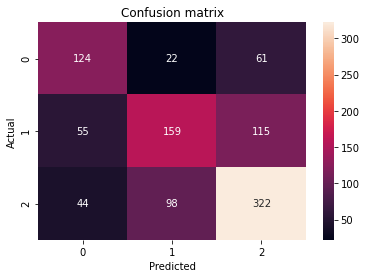

In [43]:
fig = plt.figure()
sns.heatmap(cm, annot = True, fmt='d')
plt.title("Confusion matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [44]:
accuracy = accuracy_score(y_true, y_pred)
f1Score = f1_score(y_true, y_pred, average='macro')
precisionScore = precision_score(y_true, y_pred, average='macro')
recallScore = recall_score(y_true, y_pred, average='macro')

print("Accuracy: {}\nF1-score: {}\nPrecision Score: {}\nRecall Score: {}".format(accuracy,f1Score, precisionScore, recallScore))

Accuracy: 0.605
F1-score: 0.589736390424885
Precision Score: 0.5908442100529996
Recall Score: 0.5920940028128455


# Naive Bayes Classifier

In [45]:
x_train, x_test, y_train, y_test = train_test_split(df[['cleanText']], 
                                                    df['Sentiment (2pos/1neu/0neg)'], 
                                                    test_size=0.2, 
                                                    random_state=0)

In [46]:
vectorizer = CountVectorizer(ngram_range=(1,2))
cv = vectorizer.fit_transform(x_train['cleanText'])

In [47]:
clf = MultinomialNB().fit(cv, y_train)

In [48]:
test_vector = vectorizer.transform(x_test['cleanText'])
result = clf.predict(test_vector)
cmNB = metrics.confusion_matrix(y_test, result)
cmNB

array([[ 7,  5, 27],
       [ 0, 45, 19],
       [ 1,  6, 90]])

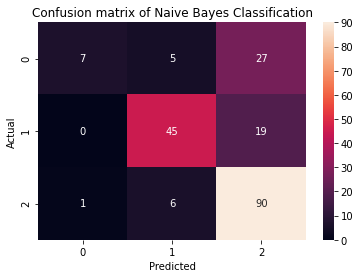

In [49]:
fig = plt.figure()
sns.heatmap(cmNB, annot = True, fmt='d')
plt.title("Confusion matrix of Naive Bayes Classification")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
# count vectorizing with unigram + bigram
accuracy = accuracy_score(y_test, result)
f1Score = f1_score(y_test, result, average='macro')
precisionScore= precision_score(y_test, result, average='macro')
recallScore = recall_score(y_test, result, average='macro')
# averagePrecision = metrics.average_precision_score(y_test, result)

# print('Average precision-recall score: {}'.format(averagePrecision))
print("Accuracy: {}\nF1-score: {}\nPrecision Score: {}\nRecall Score: {}".format(accuracy, f1Score, precisionScore, recallScore))

Accuracy: 0.71
F1-score: 0.6068015097555778
Precision Score: 0.7801120448179272
Recall Score: 0.6034824103445238
